# Synopsis
The model must be able to read in a sequence of numbers, one number at a time, and classify that number based on all previously seen numbers.

## Project TODO Steps
 1. create dataset
  - create single signal generator class
  - create mixed signal generator class
  - create noise functions (Gaussian, OU, etc.)
 2. create network
 3. train network
 4. test network

## Parameters to test
 1. sequence length
 2. amplitude
 3. frequency (period)
 4. offset
 5. phase
 6. noise
 
## Questions to answer
 1. What would a batch look like?
 2. How many LSTM layers do we need? nodes per LSTM layer?
 3. Can we learn if our timestamps are not uniformly spaced.

In [1]:
import numpy as np
import pandas as pd
from random import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

## Build a signal generator

In [4]:
from discrimnn.signal import MixedSignal

(301, 1, 2) (301, 3)


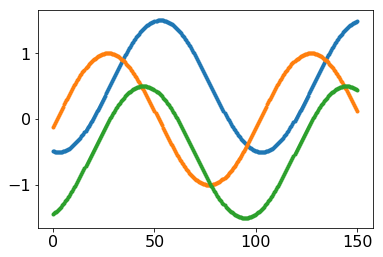

In [6]:
# start off with simplest case for proof of concept
n_timesteps = 301

sig1_coeffs = {'phase': {'delta': np.pi}, 'amplitude': {'mean': 1.0}, 'period': {'mean': 100.0}, 'offset': {'mean': 0.5}}
sig2_coeffs = {'phase': {'delta': np.pi}, 'amplitude': {'mean': 1.0}, 'period': {'mean': 100.0}, 'offset': {'mean': 0.0}}
sig3_coeffs = {'phase': {'delta': np.pi}, 'amplitude': {'mean': 1.0}, 'period': {'mean': 100.0}, 'offset': {'mean': -0.5}}
coeffs_list = [sig1_coeffs, sig2_coeffs, sig3_coeffs]

msig = MixedSignal(0, 150, n_timesteps, coeffs_list)
n_signals = len(msig)
X, y = msig()

print(X.shape, y.shape)
# print(X)
# print(y)

for i in range(n_signals):
    plt.plot(msig.timestamps, msig.signals[i], marker='.')

In [7]:
def highlight_column_matches(data, column='', color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_mixed = data == data[column]
        return [attr if v else '' for v in is_mixed]
    else:  # from .apply(axis=None)
        is_mixed = data == data[column]
        return pd.DataFrame(np.where(is_mixed, attr, ''), index=data.index, columns=data.columns)
    
df = pd.DataFrame(np.vstack((msig.signals, msig.mixed_signal)).T, index=msig.timestamps, columns=['A', 'B', 'C', 'Mixed'])
df[:5].style.apply(highlight_column_matches, column='Mixed', color='lightblue', axis=1)

,A,B,C,Mixed
0.0,-0.484822,-0.122121,-1.44091,-0.122121
0.5,-0.489788,-0.0908849,-1.42981,-1.42981
1.0,-0.493777,-0.0595592,-1.41779,-0.493777
1.5,-0.496786,-0.0281749,-1.40487,-0.496786
2.0,-0.49881,0.00323733,-1.39105,0.00323733
2.5,-0.499849,0.0346463,-1.37635,-0.499849
3.0,-0.499901,0.0660211,-1.36079,0.0660211
3.5,-0.498967,0.0973308,-1.34438,0.0973308
4.0,-0.497046,0.128544,-1.32713,-1.32713
4.5,-0.494142,0.159631,-1.30907,-1.30907


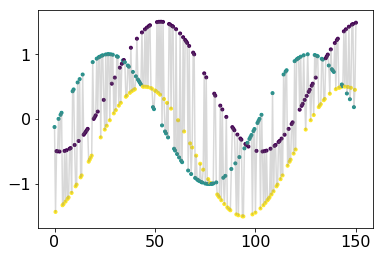

In [8]:
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.labels)

In [9]:
# define model
model = Sequential()
# model.add(Masking(mask_value=-1, input_shape=(1,)))
# model.add(LSTM(5))
# model.add(LSTM(5, input_shape=(2, 1)))
model.add(LSTM(16, return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(16))
# model.add(LSTM(5, input_shape=(n_timesteps, 2)))
model.add(Dense(n_signals, activation='softmax'))


# model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))
# model.add(LSTM(32, return_sequences=True))
# model.add(LSTM(32))

# model.add(LSTM(2048, return_sequences=False, input_shape=self.input_shape, dropout=0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

for i in range(100):
#     X, y = msig.generate_batch(64)
    X, y = msig.generate()
    model.fit(X, y, epochs=1, batch_size=1, verbose=1, shuffle=False)
#     model.reset_states()
#     model.fit(X, y, epochs=1, batch_size=1, verbose=2)

x_test, y_test = msig.generate()
score = model.evaluate(x_test, y_test, batch_size=1)
print(score)

Epoch 1/1
301/301 [==============================] - 2s 6ms/step - loss: 1.0995 - acc: 0.3588
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.0956 - acc: 0.3821
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.0916 - acc: 0.3422
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.0457 - acc: 0.4651
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 0.9980 - acc: 0.4917
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 0.8287 - acc: 0.6711
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 0.5663 - acc: 0.8073
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.1698 - acc: 0.5648
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.2268 - acc: 0.4917
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 0.9002 - acc: 0.5382
Epoch 1/1
301/301 [==============================] - 1s 2ms/

301/301 [==============================] - 1s 2ms/step - loss: 0.9122 - acc: 0.6445
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.0786 - acc: 0.7076
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.0492 - acc: 0.6080
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 0.7757 - acc: 0.6645
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 0.8812 - acc: 0.7940
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 0.3565 - acc: 0.8571
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.3857 - acc: 0.4286
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.2915 - acc: 0.4153
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.1040 - acc: 0.4917A: 0s - loss: 1.1055 - acc: 0.488
Epoch 1/1
301/301 [==============================] - 1s 2ms/step - loss: 1.0996 - acc: 0.4120
Epoch 1/1
301/301 [==================

In [ ]:
y_hat = model.predict(x_test)
for i in range(len(x_test)):
    print('Expected', y_test[i], 'Predicted', y_hat[i])

(301, 1, 2)
(301, 3)
(301,)
(301,)


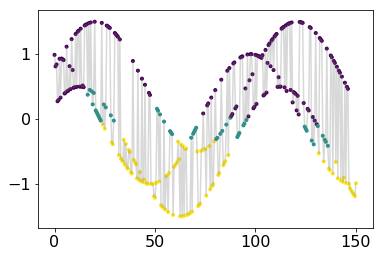

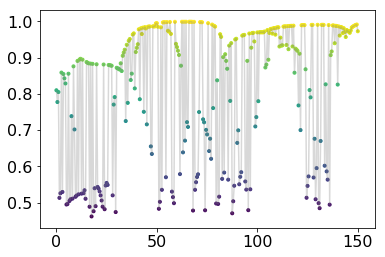

In [10]:
x_test, y_test = msig.generate()
print(x_test.shape)
y_hat = model.predict(x_test)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = np.max(y_hat, axis=1)
# y_error = msig.labels - y_hat
print(y_error.shape)
plt.plot(msig.timestamps, x_test[:, 0, 1], color='grey', alpha=0.3)
plt.scatter(msig.timestamps, x_test[:, 0, 1], marker='.', c=y_pred)
plt.show()

plt.plot(msig.timestamps, y_error, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, y_error, marker='.', c=y_error)
plt.show()